/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning:

divide by zero encountered in divide

/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1311: RuntimeWarning:

divide by zero encountered in divide

/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1317: RuntimeWarning:

invalid value encountered in add



<Axes: >

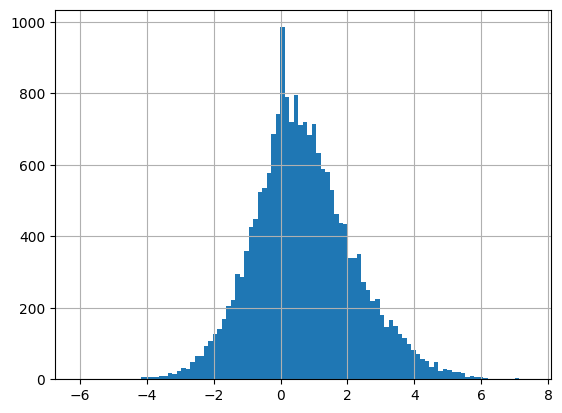

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Bfield_Mz_45_10_10_10_Ht_1_ncycles_12.csv')
df_H0 = pd.read_csv('Bfield_Mz_45_10_10_10_Ht_0_ncycles_18.csv')

df['dMdB'] = np.gradient(df['M_z'], df['B_Field'])
df['dMdB'].hist(bins = 100)

In [134]:
#Accidentally set number of loops different for H = 0 and H = 1, so drop the extra rows in H = 0
# Calculate number of rows to keep (first 2/3)
n_rows = len(df_H0)
cutoff = n_rows * 2 // 3  # floor division

# Keep only the first 2/3
df_H0 = df_H0.iloc[:cutoff].reset_index(drop=True)

/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning:

divide by zero encountered in divide

/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1311: RuntimeWarning:

divide by zero encountered in divide

/Users/jiakai/Desktop/SURF/code/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1317: RuntimeWarning:

invalid value encountered in add



<Axes: >

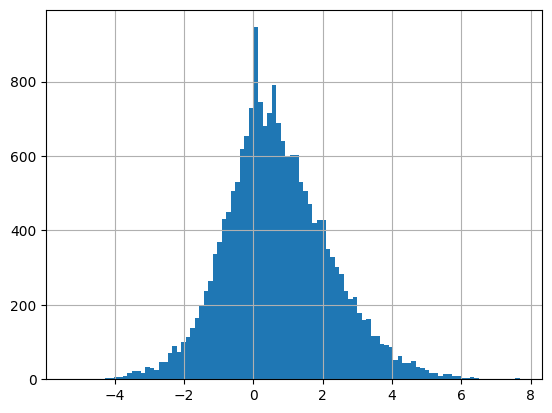

In [135]:
df_H0['dMdB'] = np.gradient(df_H0['M_z'], df_H0['B_Field'])
df_H0['dMdB'].hist(bins = 100)

In [136]:
import plotly.graph_objects as go

# Create plotly figure
fig = go.Figure()

# Add first dataset (Ht = 1)
fig.add_trace(go.Scatter(
    x=df['B_Field'],
    y=df['M_z'],
    mode='lines',
    name='Ht = 1'
))

# Add second dataset (Ht = 0)
fig.add_trace(go.Scatter(
    x=df_H0['B_Field'],
    y=df_H0['M_z'],
    mode='lines',
    name='Ht = 0'
))

# Update layout
fig.update_layout(
    title='Hysteresis Curves: M_z vs B_Field',
    xaxis_title='B Field (T)',
    yaxis_title='M_z',
    legend_title='Tunneling Field (Ht)',
    template='plotly_white',
    width=800,
    height=500
)

# Show plot
fig.show()

In [103]:
import plotly.express as px
fig = px.line(df, x='B_Field', y='M_z', markers=True,
              labels={'B_Field': 'B Field', 'M_z': 'M_z'},
              title='M_z vs. B Field')
fig = px.line(df_H0, x='B_Field', y='M_z', markers=True,
              labels={'B_Field': 'B Field', 'M_z': 'M_z'},
              title='M_z vs. B Field')

# Add a label column to distinguish the datasets
df['label'] = 'H_t = 1'
df_H0['label'] = 'H_t = 0'

# Combine the DataFrames
combined_df = pd.concat([df, df_H0])

# Plot
fig = px.line(
    combined_df,
    x='B_Field',
    y='M_z',
    color='label',  # Use color to distinguish
    markers=True,
    labels={'B_Field': 'B Field', 'M_z': 'M_z', 'label': 'Relaxation Field'},
    title='M_z vs. B Field for Different H_relax'
)

fig.write_html("Bfield_Mz_10_10_10_Ht_1_Ht_0_ncycles_8.html")

In [137]:
threshold = 5
#Only check between the two segments of abs(B_limit_up) -> abs(B_limit_down) and its mirror image across y-axis
B_limit_up = 2
B_limit_down = 0

In [138]:
#Find continuous segments of rows that contain at least one row with dMdB > threshold, segment defined by endpoints turning negative

def get_large_avals(df):
    large_avals = [] # list of (dB, dM)
    has_large = False
    segment_started = False
    B_segment_start = 0
    M_segment_start = 0



    for i in range(len(df)):
        if abs(df['B_Field'].iloc[i])>B_limit_up or abs(df['B_Field'].iloc[i])<B_limit_down:
            segment_started = False
            has_large = False
            continue

        dMdB = df['dMdB'].iloc[i]
        if segment_started:
            if  dMdB > 0:
                if dMdB > threshold:
                    has_large = True
            else:
                dB = abs(B_segment_start - df['B_Field'].iloc[i])
                dM = abs(M_segment_start - df['M_z'].iloc[i])
                if has_large:
                    large_avals.append((dM, dB))
                segment_started = False
                has_large = False

        else:
            if dMdB>0:
                segment_started = True
                B_segment_start = df['B_Field'].iloc[i]
                M_segment_start = df['M_z'].iloc[i]
                if dMdB > threshold:
                    has_large = True


    return large_avals


In [139]:
large_avals_H0 = get_large_avals(df_H0)

arr_H0 = np.array(large_avals_H0)

large_avals = get_large_avals(df)

arr = np.array(large_avals)

# plt.figure(figsize=(6,5))
# plt.scatter(arr[:,1], arr[:,0], color='blue', label='H_t = 1T')
# plt.scatter(arr_H0[:,1], arr_H0[:,0], color='red', label='H_t = 0T')
# plt.ylabel('dM')
# plt.xlabel('dB')
# plt.title('Scatter plot of (dM, dB)')
# plt.grid(True)
# plt.tight_layout()
# plt.legend()
# plt.show()
# plt.savefig('Bfield_Mz_10_10_10_Ht_1_ncycles_8.png')

# Create Plotly figure
fig = go.Figure()

xmin = min(arr[:,1].min(), arr_H0[:,1].min())
xmax = max(arr[:,1].max(), arr_H0[:,1].max())
ymin = min(arr[:,0].min(), arr_H0[:,0].min())
ymax = max(arr[:,0].max(), arr_H0[:,0].max())


# Scatter for H_t = 1T (blue)
fig.add_trace(go.Scatter(
    x=arr[:, 1],  # dB
    y=arr[:, 0],  # dM
    mode='markers',
    marker=dict(color='blue'),
    name='H_t = 1T'
))

# Scatter for H_t = 0T (red)
fig.add_trace(go.Scatter(
    x=arr_H0[:, 1],  # dB
    y=arr_H0[:, 0],  # dM
    mode='markers',
    marker=dict(color='red'),
    name='H_t = 0T'
))

# Layout styling
fig.update_layout(
    title='Scatter plot of (dM, dB)',
    xaxis_title='dB',
    yaxis_title='dM',
    legend=dict(title='Transverse Field'),
    template='plotly_white',
    width=600,
    height=500,
    xaxis=dict(
        title='dB',
        # range=[xmin, xmax],
        # type='log',
        # fixedrange=True       # disables zooming/panning on this axis
    ),
    yaxis=dict(
        title='dM',
        # range=[ymin, ymax],
        type='log',
        # fixedrange=True       # optional: locks interaction
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    showlegend=True,
    grid=dict(rows=1, columns=1)
)

# Show interactive plot
fig.show()